# Libraries

In [18]:
import csv
import os
import re
import json
import umap
import textacy
import hdbscan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
from IPython.display import clear_output
from pointgrid import align_points_to_grid
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

import math
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
from scipy import interpolate


# Import

## Articles

In [19]:
articles = []

dir = "data/biomass/"
files = os.listdir(dir)  # Set folder and files

for filename in files:

    f = open(dir + filename)
    r = f.read()
    data = json.loads(r)

    # Parse

    try:

        year = int(data[0]["publish_date"].split(" ")[0].split("-")[0])  # Set year

        title = data[0]["title"]  # Title
        
        url = data[0]["url"]  # URL
        if any(x in url for x in {"feeds.", "rss.", "briefing"}): continue  # Blacklist (Bob Dylan's case)

        entities = data[0]["story_tags"]  # Set sentities
        if len(entities) > 100: continue  # Filter max
        if len(entities) <= 1: continue  # Filter min

        subjects = []
        orgs = []
        people = []

        for entity in entities:

            name = entity["tag"]

            if name[0] == "—": continue  # Remove listings
            if name.startswith("geonames_"): continue  # Skip geotag
            if "readability" in name: continue  # Clean
            if "cliff_clavin_" in name: continue  # Clean
            if "nyt_labeller" in name: continue  # Clean

            # print('name', name)
            cleaned = re.sub(r"\([^()]*\)", "", name) # Remove brackets with text
            name = cleaned
            name = " ".join(name.split())  # Merge multiple spaces
            name = name.lstrip() # Remove leading whitespaces
            name = name.replace(".", "")  # Remove dots
            name = name.replace(",", "")  # Remove commas

            # print('name', name)

            if name in {'World Health Organisation'}: continue  # Stopwords

            if entity["tag_set"] == "nyt_labels":
                subjects.append(name)

            elif entity["tag_set"] == "cliff_organizations":
                if name.startswith("US "): name = name[3:]  # Remove prefix
                if name.endswith(" Corp"): name = name[:-5]  # Remive postfix
                if name.endswith(" Inc"): name = name[:-4]  # Remive postfix
                if name.endswith(" LCC"): name = name[:-4]  # Remive postfix
                if name[0].islower(): continue  # Remove lowercase
                if name[1].isupper(): continue  # Remove acronyms
                orgs.append(name)

            elif entity["tag_set"] == "cliff_people":
                if "/" in name: continue  # Clean
                if name[1].isupper(): continue  # Remove uppercase
                if name[0].islower(): continue  # Remove lowercase
                if len(name.split(" ")) == 1: continue  # remove those with no family name
                people.append(name)

        if len(orgs) > 0 and len(subjects) > 0:
            articles.append(
                [
                    year,
                    title,
                    url,
                    list(set(subjects)),
                    list(set(orgs)),
                    list(set(people)),
                ]
            ) # Add these articles with actors only

    except:
        continue  # In case of error



articles = pd.DataFrame(
    articles, columns=["year", "title", "url", "subjects", "orgs", "people"]
).drop_duplicates(subset=["url"])  # Remove articles with the same URL

print('The number of articles is ' + str(articles.shape[0]))

articles.sample(1)


The number of articles is 18126


,year,title,url,subjects,orgs,people
6050,2014,Meet on power electronics,http://www.thehindubusinessline.com/news/state...,"[research, energy and power, computers and the...","[Purdue University, Nitte University]","[Shripad T Revankar, Vinay Hegde]"


## Entities

In [20]:
entities = np.empty((0, 12), dtype=object)

years_template = { 2011:0, 2012:0, 2013:0, 2014:0, 2015:0, 2016:0, 2017:0, 2018:0, 2019:0, 2020:0 }

def update(entity, type): # Function for writing

    global entities
    co = cooccurrences.copy()
    co.remove(entity)
    index = np.where(entities[:, 0] == entity)[0]

    if index.size == 0:
        entities = np.append(
            entities,
            np.array(
                [
                    [
                        entity,
                        type,
                        1,
                        None,
                        None,
                        -1,
                        -1,
                        -1,
                        years_template.copy(),
                        [url],
                        [title],
                        co,
                    ]
                ],
                dtype=object,
            ),
            axis=0,
        )
        entities[len(entities) - 1][8][year] = 1  # Add year
    else:
        entities[index, 2] += 1  # Frequency
        entities[index, 8][0][year] += 1  # Year
        entities[index, 9][0].append(url)  # URL
        entities[index, 10][0].append(title)  # Title
        entities[index, 11][0] += co  # Co-occurrences


for index, row in articles.iterrows(): # Iteration on all the articles

    url = row["url"]
    year = row["year"]
    title = row["title"]
    cooccurrences = list(set(row["subjects"] + row["orgs"] + row["people"]))

    for entity in row["subjects"]:
        update(entity, "subject")

    for entity in row["orgs"]:
        update(entity, "org")
      
    for entity in row["people"]:
        update(entity, "person")

# Numpy to Pandas

entities_all = pd.DataFrame(
    entities,
    columns=[
        "name",
        "type",
        "frequency",
        "slope",
        "color",
        "x",
        "y",
        "cluster",
        "years",
        "urls",
        "titles",
        "cooccurrences",
    ],
)  # Dataset
entities_all = entities_all.astype({
    "name": "str",
    "type": "str",
    "frequency": "int",
    "slope": "float",
    "color": "str",
    "x": "int",
    "y": "int",
    "cluster": "int",
    "years": "object",
    "urls": "object",
    "titles": "object",
    "cooccurrences": "object",
})


print('The total number of entities is', len(entities))

entities_all.sort_values(by=["frequency"], ascending=False).head(1)


The total number of entities is 68327


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences
14,environment,subject,7492,NaN,None,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 484, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me..."


# Treatment

## Narmalization

In [21]:
# Frequency scale

frequency = entities_all['frequency'].to_numpy().reshape(-1, 1)
min_max_scaler = preprocessing.MinMaxScaler()
frequency_scaled = min_max_scaler.fit_transform(frequency)
entities_all['frequency_norm'] = frequency_scaled

# Transfrom dictionary into JSON

for index, row in entities_all.iterrows():
  entities_all.loc[index, "years_JSON"] = json.dumps(row['years'])

entities_all.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
27129,Jon Shenk,person,1,NaN,None,-1,-1,-1,"{2011: 0, 2012: 0, 2013: 0, 2014: 0, 2015: 0, ...",[https://www.washingtonpost.com/news/powerpost...,[Analysis | The Energy 202: How Pruitt's hustl...,"[White House, Alaska Daily News, George W Bush...",0.0,"{""2011"": 0, ""2012"": 0, ""2013"": 0, ""2014"": 0, ""..."


## Filter

In [22]:
n = 50 # Number of rows by type

top_subjects = entities_all.loc[entities_all['type'] == 'subject'].sort_values(by=["frequency"], ascending=False).head(n * 3)
top_orgs = entities_all.loc[entities_all['type'] == 'org'].sort_values(by=["frequency"], ascending=False).head(n)
top_people = entities_all.loc[entities_all['type'] == 'person'].sort_values(by=["frequency"], ascending=False).head(n)

entities = pd.concat([top_subjects, top_orgs, top_people])

entities.sample(1)

,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
1434,YouTube,org,103,NaN,None,-1,-1,-1,"{2011: 1, 2012: 2, 2013: 3, 2014: 3, 2015: 0, ...",[https://townhall.com/columnists/hsterlingburn...,[Climate Attack Dogs Target Michael Moore for ...,"[Sierra Club, Bernie Sanders, energy and power...",0.013616,"{""2011"": 1, ""2012"": 2, ""2013"": 3, ""2014"": 3, ""..."


## Linear Regression

In [23]:
# For each

for i, row in entities.iterrows():
    
    x = list(row['years'].keys())
    x = np.array(x).reshape((-1, 1))  # Needed for one-column values
    y = list(row['years'].values())

    regression = LinearRegression()
    regression.fit(x, y)

    slope = regression.coef_[0]
    entities.at[i, 'slope'] = slope


# Average and slope difference for subjects

entities_subjects = entities.loc[entities['type'] == 'subject']
average_subjects = entities_subjects['slope'].mean()
for i, row in entities_subjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_subjects


# Average and slope difference for people and organizations

entities_nosubjects = entities.loc[entities['type'] != 'subject']
average_nosubjects = entities_nosubjects['slope'].mean()
for i, row in entities_nosubjects.iterrows():
    entities.at[i, 'slope'] = row['slope'] - average_nosubjects


# entities.sort_values(by=["slope"], ascending=False).head(1)
# average_subjects, average_nosubjects
entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2525,genetic engineering,subject,26,-8.936364,None,-1,-1,-1,"{2011: 1, 2012: 4, 2013: 0, 2014: 5, 2015: 3, ...",[https://www.bbc.co.uk/news/science-environmen...,[Genetically modified 'shortcut' boosts plant ...,"[research, Amanda Cavanagh, medicine and healt...",0.003337,"{""2011"": 1, ""2012"": 4, ""2013"": 0, ""2014"": 5, ""..."


## Colors

In [24]:
import matplotlib.colors as mcolors

cmap = plt.cm.coolwarm
norm = matplotlib.colors.TwoSlopeNorm(vmin=-1, vcenter=0, vmax=1)

for i, row in entities.iterrows():
    
    if row['type'] != 'subject':
        entities.at[i, 'color'] = mcolors.to_hex(cmap(norm(row['slope']))) # Actors
    else:
        entities.at[i, 'color'] = '#CCCCCC' # Subjects

# entities.sort_values(by=["slope"], ascending=False).head(1)
entities.head(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
14,environment,subject,7492,150.348485,#CCCCCC,-1,-1,-1,"{2011: 184, 2012: 147, 2013: 355, 2014: 484, 2...",[http://www.newindianexpress.com/cities/delhi/...,[Air quality improves in Delhi as rainfall was...,"[Sunil Dahiya, Indian Institute of Tropical Me...",1.0,"{""2011"": 184, ""2012"": 147, ""2013"": 355, ""2014""..."


# Embedding

## Term Frequency

In [25]:


doc_term_matrix, dictionary = textacy.representations.build_doc_term_matrix(
    # entities["cooccurrences"].tolist(), tf_type="linear", idf_type="standard"
    entities["cooccurrences"].tolist(), tf_type="linear", idf_type="smooth"
)

list(dictionary.items())[:5]


[('Sunil Dahiya', 59556),
 ('Indian Institute of Tropical Meteorology', 27608),
 ('Greenpeace India', 24464),
 ('Karan Madan', 33345),
 ('Imperial College of London', 27435)]

## UMAP

In [26]:
reducer = umap.UMAP(
    random_state=42,
    n_components=2,
    n_neighbors=4,
    min_dist=0.2,
    metric="hellinger",
)

embedding = reducer.fit_transform(doc_term_matrix)  # Reducer
embedding = align_points_to_grid(embedding) # Alignment to a grid

scaler = MinMaxScaler(feature_range=(100, 900))  # Scale
embedding = scaler.fit_transform(embedding)
embedding = embedding.astype(int)

index_embedding = 0  # Writing values in the dataset
for index, row in entities.iterrows():
    entities.loc[index, "x"] = embedding[:, 0][index_embedding]
    entities.loc[index, "y"] = embedding[:, 1][index_embedding]
    index_embedding += 1

entities.sample(1)


OMP: Info #271: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


 * creating mesh with size 50 50
 * filling mesh


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2662,Washington Post,org,134,-1.033091,#3b4cc0,230,606,-1,"{2011: 1, 2012: 2, 2013: 11, 2014: 8, 2015: 20...",[http://www.countercurrents.org/2016/08/25/dam...,[Dam Building: Who&#8217;s &#8220;Backward&#82...,"[Kapil Bhattacharya, Nehru Memorial Museum, Na...",0.017755,"{""2011"": 1, ""2012"": 2, ""2013"": 11, ""2014"": 8, ..."


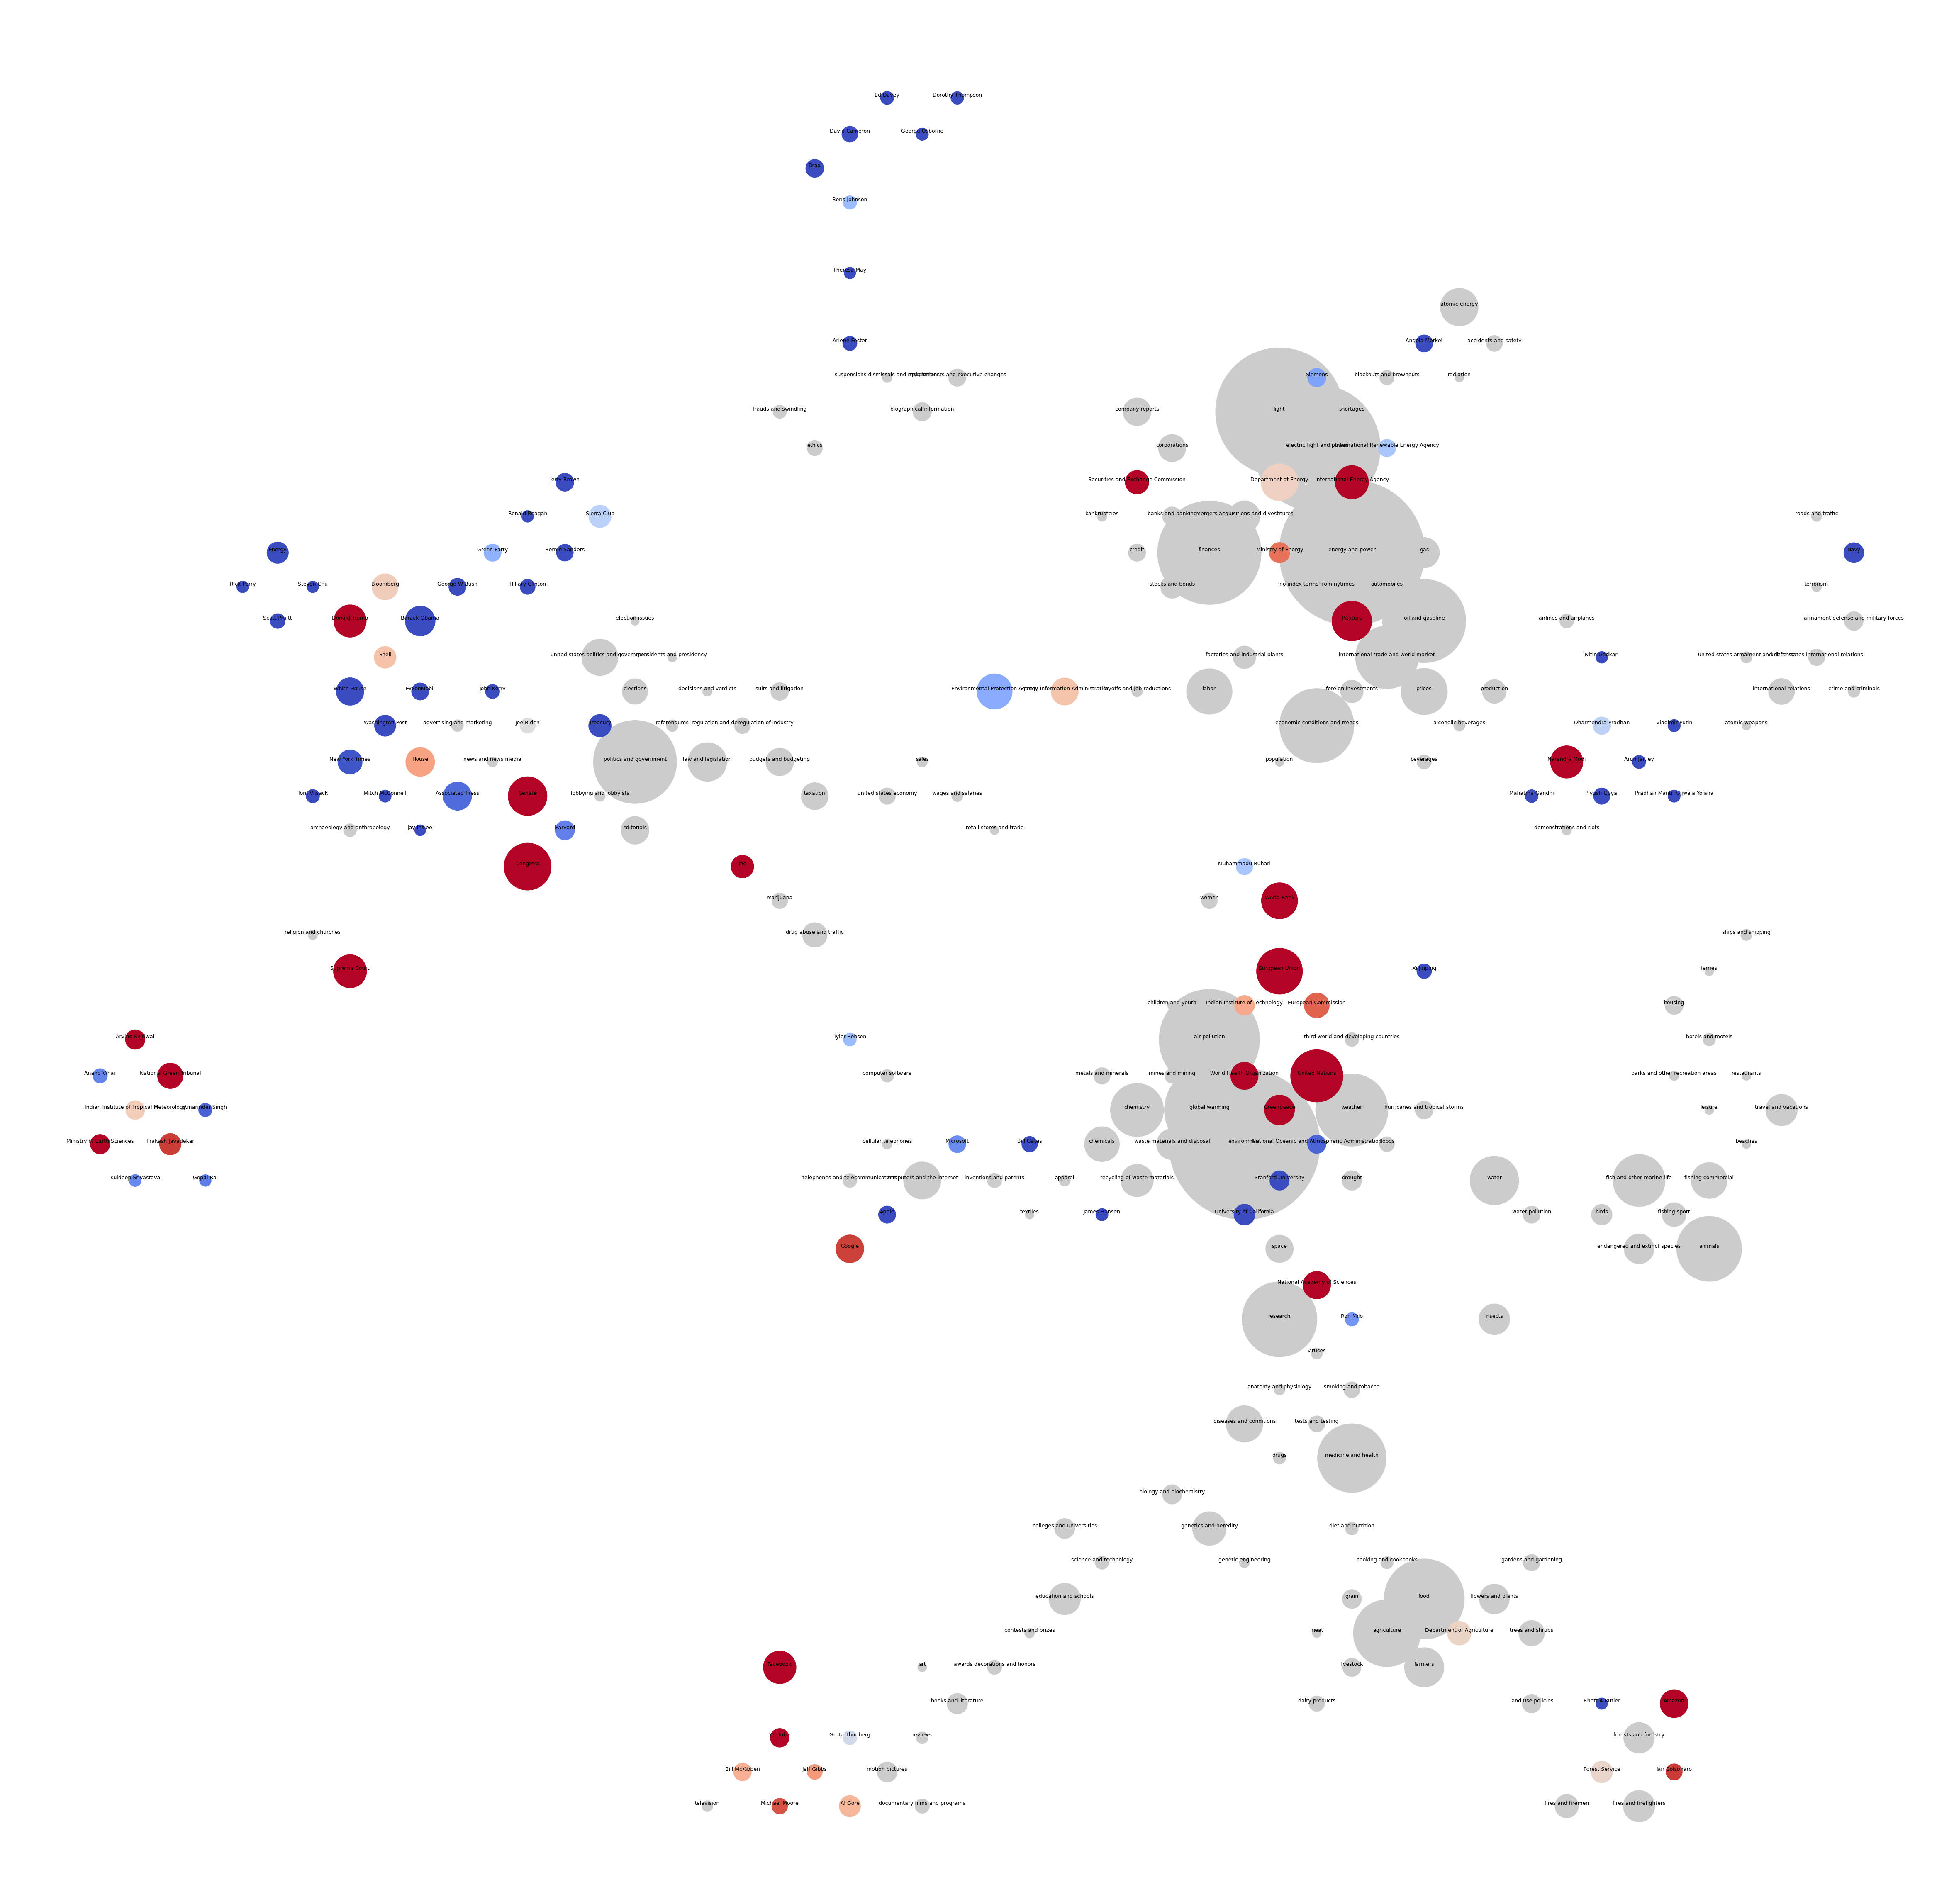

In [27]:
plt.figure(figsize=(20, 20), dpi=300)
plt.axis("off")

# Scatterplot

plt.scatter(
    entities["x"].to_list(),
    entities["y"].to_list(),
    s=entities["frequency"].to_list(),
    c=entities["color"].to_list(),
)

# Labels

for i, row in entities.iterrows():
    text = plt.annotate(row["name"], xy=(row["x"], row["y"]), ha="center", va="bottom")
    text.set_fontsize(3)

plt.savefig("download.png")

## Clustering

In [28]:
clusterer = hdbscan.HDBSCAN(
    # min_samples=1,  
    min_cluster_size=3, # 2 — which means 3 elements — is the smallest cluster size
    # cluster_selection_epsilon=50,   # float, optional (default=0.0) A distance threshold. Clusters below this value will be merged.
    # gen_min_span_tree=False,
    # leaf_size=10, # int, optional (default=40) If using a space tree algorithm (kdtree, or balltree) the number of points ina leaf node of the tree. This does not alter the resulting clustering, but may have an effect on the runtime of the algorithm.
)

entities['cluster'] = '-1' # Reset

def cluster_computing(rows, prefix, entities):

    embedding = rows[["x", "y"]].to_numpy()
    clusterer.fit(embedding)
    clusters = clusterer.labels_
    
    # Write cluster number

    for count, (index, row) in enumerate(rows.iterrows()):
        if clusters[count] != -1:
            entities.loc[index, 'cluster'] = prefix + str(clusters[count])
        else:
            entities.loc[index, 'cluster'] = str(clusters[count])
    
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] > 0)], 'p_', entities)
cluster_computing(entities.loc[(entities["type"] != "subject") & (entities["slope"] < 0)], 'n_', entities)

entities.sample(1)


,name,type,frequency,slope,color,x,y,cluster,years,urls,titles,cooccurrences,frequency_norm,years_JSON
2822,beaches,subject,19,-8.833333,#CCCCCC,851,410,-1,"{2011: 2, 2012: 0, 2013: 2, 2014: 1, 2015: 2, ...",[http://feedproxy.google.com/~r/newscomauqldnd...,"[Government opens green zones to fishing, Beac...","[fish and other marine life, leisure, Steve Di...",0.002403,"{""2011"": 2, ""2012"": 0, ""2013"": 2, ""2014"": 1, ""..."


{'n_1', 'n_0', 'p_4', 'p_3', 'p_0', 'n_4', 'p_2', 'p_5', 'n_3', 'p_1', 'n_2'}
[426 442 491 459 426]
[148 100 116 148 148]
[622 655 655 638 622 622]
[230 214 246 295 295 230]
[442 393 410 442 442]
[704 442 459 671 704]
[116 100 132 214 116]
[573 671 671 573]
[785 753 818 818 785]
[818 720 785 818 818]
[165 197 246 312 328 328 312 181 165]


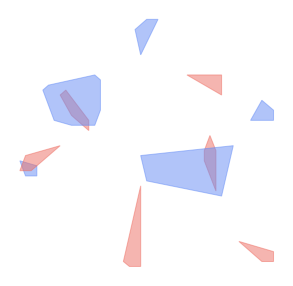

In [29]:
plt.figure(figsize=(5, 5))
plt.axis("off")

clusters = set(entities["cluster"].tolist())
clusters.remove("-1")  # Remove -1

print(clusters)

hulls = []

for counter, cluster in enumerate(clusters):

    points = []  # Points
    rows = entities.loc[entities["cluster"] == cluster]  # Rows
    
    for index, row in rows.iterrows():
        points.append([row["x"], row["y"]])
    points = np.array(points)
    
    hull = ConvexHull(points)  # Hull
    x_hull = np.append(points[hull.vertices, 0], points[hull.vertices, 0][0])
    y_hull = np.append(points[hull.vertices, 1], points[hull.vertices, 1][0])

    print(x_hull)
    
    hulls.append([hull, cluster[0]])
    
    if cluster[0] == 'p':
        plt.fill(x_hull, y_hull, "--", c="#ED6D62", alpha=0.5)  # Plot red
    else:
        plt.fill(x_hull, y_hull, "--", c="#648BF5", alpha=0.5)  # Plot blue


In [30]:
import itertools

for x, y in itertools.permutations(hulls, 2):
    print(x, y)
    

[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff7165730>, 'n']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff71659a0>, 'p']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff7165be0>, 'p']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fc000f89f70>, 'p']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff7165490>, 'n']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff71365b0>, 'p']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.ConvexHull object at 0x7fbff7165f40>, 'p']
[<scipy.spatial.qhull.ConvexHull object at 0x7fbff71655b0>, 'n'] [<scipy.spatial.qhull.Con

# Save

In [31]:
entities.to_csv("src/data/entities.csv", index=False)